In [66]:
%%bash
#conda update anaconda
#pip install pyldavis

In [1]:
import pandas as pd
import numpy as np
from gensim import corpora, models, similarities
import pickle
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO
from ast import literal_eval
import itertools
import pyLDAvis

In [2]:
dropbox = "/Users/mr/Dropbox/moviemeta/"

In [48]:
def iterdocs(filepath):
    for line in open (filepath):
        yield literal_eval(line)
            
class Corpus(object):    
    def __init__(self, filename, excludes):
        self.filepath = dropbox + filename
        self.dictionary = corpora.Dictionary(iterdocs(self.filepath))
        #filter out the words with very low and very high document frequency
        self.dictionary.filter_extremes() 
        exclude_ids = []
        for token in excludes:
            exclude_ids.append(self.dictionary.token2id[token])
        self.dictionary.filter_tokens(exclude_ids)
    def __iter__(self):
        for doc in iterdocs(self.filepath):
            yield self.dictionary.doc2bow(doc)

In [34]:
corpus = Corpus('imdb_plots_since_2014.list',[])
dictionary = corpus.dictionary

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:adding document #10000 to Dictionary(31506 unique tokens: [u'fawn', u'isis-isil', u'fawk', u'woodi', u'chthonic']...)
INFO:gensim.corpora.dictionary:built Dictionary(42120 unique tokens: [u'fawn', u'dis-inform', u'fawl', u'isis-isil', u'fawk']...) from 16943 documents (total 722895 corpus positions)
INFO:gensim.corpora.dictionary:discarding 31858 tokens: [(u'hathaway', 4), (u'mlb', 2), (u'niqu', 2), (u'philanthropi', 2), (u'cho', 4), (u'busk', 4), (u'teo', 4), (u'brake', 3), (u'stefanescu', 1), (u'nothing', 2)]...
INFO:gensim.corpora.dictionary:keeping 10262 tokens which were in no less than 5 and no more than 8471 (=50.0%) documents
INFO:gensim.corpora.dictionary:resulting dictionary: Dictionary(10262 unique tokens: [u'woodi', u'foul', u'elvi', u'jihad', u'suzann']...)


In [35]:
dfs = sorted(dictionary.dfs.items(), key=lambda x : x[1], reverse=True)
words = [dictionary[tup[0]] for tup in dfs]
dfcounts = [tup[1] for tup in dfs]

In [36]:
def plot_dfs(words, counts,top=True, num=20):
    if top == True:
        words = words[:num]
        counts = counts[:num]
    else:
        words = words[-num:]
        counts = counts[-num:]
    plt.figure(figsize=(20,10))
    plt.bar(range(num), counts, color=sns.color_palette()[0])
    plt.xticks(range(num),words)
    plt.show()

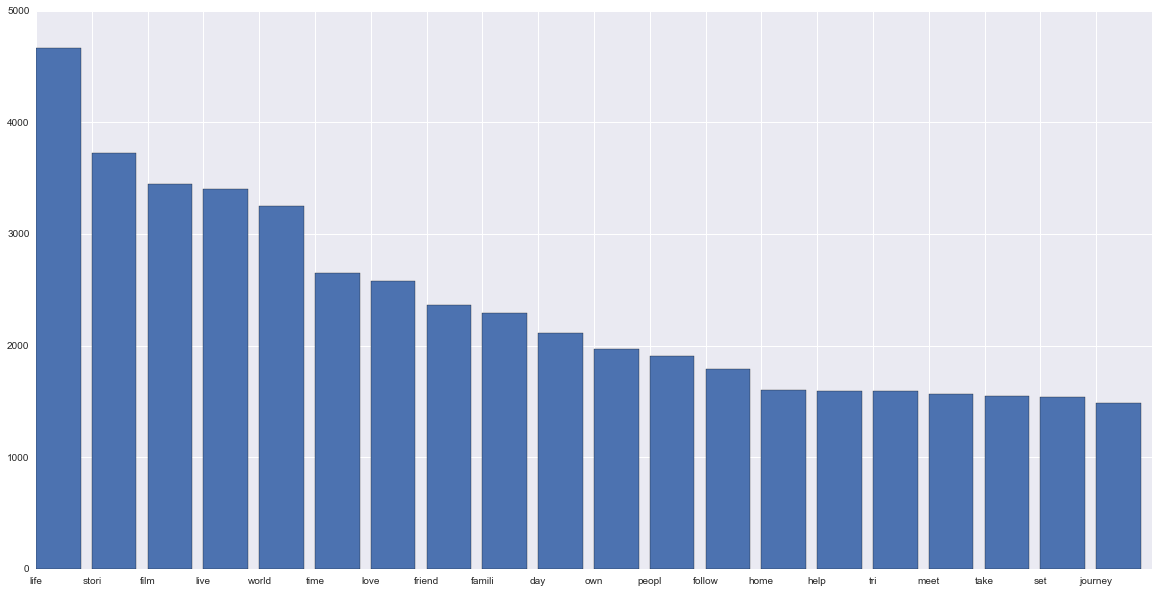

In [37]:
plot_dfs(words, dfcounts)

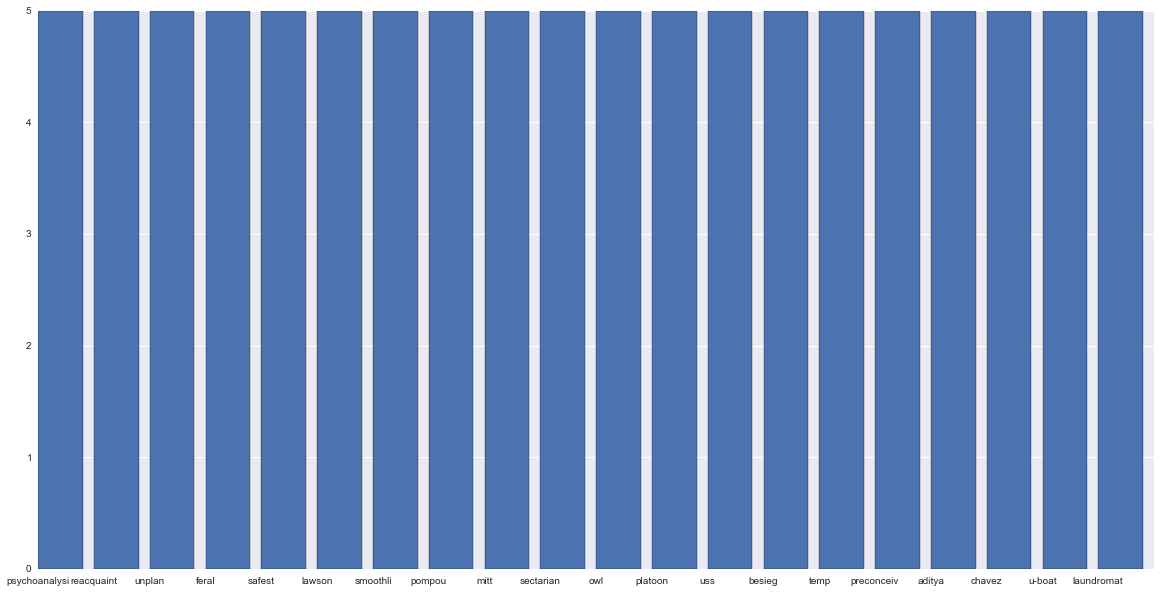

In [38]:
plot_dfs(words, dfcounts, top = False)

In [39]:
print words[:100]

[u'life', u'stori', u'film', u'live', u'world', u'time', u'love', u'friend', u'famili', u'day', u'own', u'peopl', u'follow', u'home', u'help', u'tri', u'meet', u'take', u'set', u'journey', u'chang', u'girl', u'forc', u'discov', u'begin', u'documentari', u'father', u'woman', u'struggl', u'start', u'decid', u'person', u'citi', u'come', u'dream', u'past', u'look', u'mother', u'tell', u'death', u'night', u'relationship', u'lead', u'call', u'leav', u'mysteri', u'explor', u'school', u'power', u'human', u'fight', u'secret', u'town', u'return', u'true', u'event', u'final', u'name', u'bring', u'learn', u'experi', u'hope', u'war', u'fall', u'run', u'hous', u'move', u'happen', u'play', u'save', u'soon', u'commun', u'short', u'dark', u'wife', u'kill', u'beauti', u'creat', u'boy', u'murder', u'surviv', u'left', u'charact', u'realiz', u'feel', u'search', u'music', u'son', u'daughter', u'american', u'plan', u'goe', u'littl', u'question', u'futur', u'countri', u'women', u'inspir', u'real', u'histori']

In [49]:
excludes = [u'life', u'stori', u'film', u'live', u'world', u'time',  u'day', u'own', u'peopl', u'follow', u'meet',
u'take', u'set', u'come', u'look', u'tell', u'call', u'name', u'bring', u'happen', u'soon', u'goe', u'littl']

In [50]:
newcorpus = Corpus('imdb_plots_since_2014.list', excludes)

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:adding document #10000 to Dictionary(31506 unique tokens: [u'fawn', u'isis-isil', u'fawk', u'woodi', u'chthonic']...)
INFO:gensim.corpora.dictionary:built Dictionary(42120 unique tokens: [u'fawn', u'dis-inform', u'fawl', u'isis-isil', u'fawk']...) from 16943 documents (total 722895 corpus positions)
INFO:gensim.corpora.dictionary:discarding 31858 tokens: [(u'hathaway', 4), (u'mlb', 2), (u'niqu', 2), (u'philanthropi', 2), (u'cho', 4), (u'busk', 4), (u'teo', 4), (u'brake', 3), (u'stefanescu', 1), (u'nothing', 2)]...
INFO:gensim.corpora.dictionary:keeping 10262 tokens which were in no less than 5 and no more than 8471 (=50.0%) documents
INFO:gensim.corpora.dictionary:resulting dictionary: Dictionary(10262 unique tokens: [u'woodi', u'foul', u'elvi', u'jihad', u'suzann']...)


In [51]:
newdictionary = newcorpus.dictionary
newdfs = sorted(newdictionary.dfs.items(), key=lambda x : x[1], reverse=True)
newwords = [newdictionary[tup[0]] for tup in newdfs]
newdfcounts = [tup[1] for tup in newdfs]

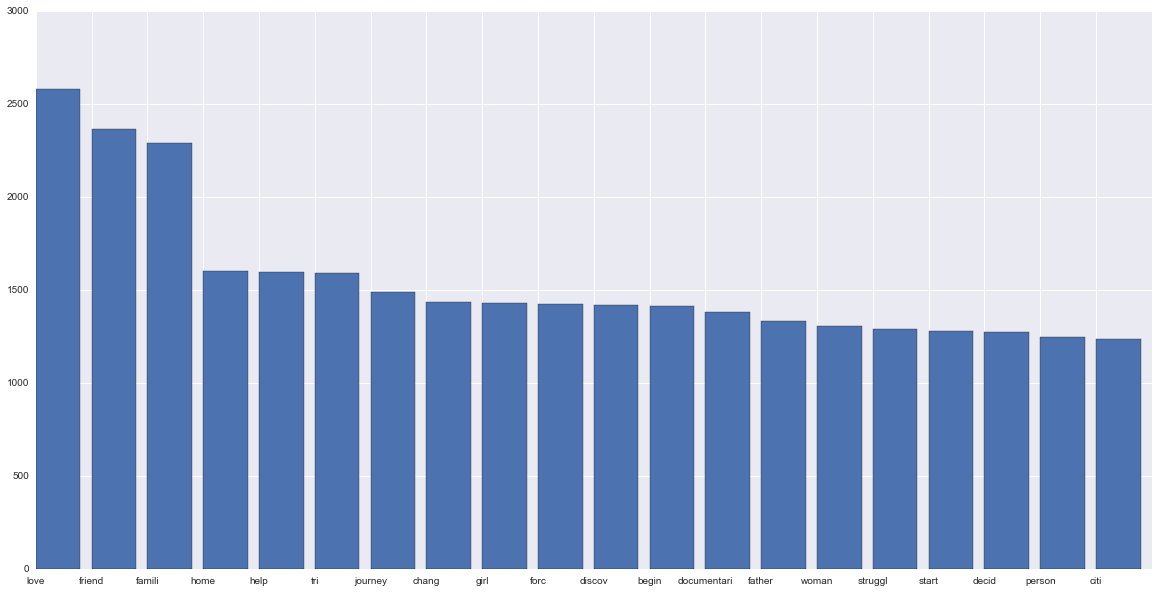

In [52]:
plot_dfs(newwords, newdfcounts)

In [63]:
tfidf = models.TfidfModel(newcorpus)
corpus_tfidf = tfidf[newcorpus]

INFO:gensim.models.tfidfmodel:collecting document frequencies
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #0
INFO:gensim.models.tfidfmodel:PROGRESS: processing document #10000
INFO:gensim.models.tfidfmodel:calculating IDF weights for 16943 documents and 10238 features (556876 matrix non-zeros)


In [64]:
lsi = models.LsiModel(corpus_tfidf, id2word=newdictionary, num_topics=20)
corpus_lsi = lsi[corpus_tfidf] 

INFO:gensim.models.lsimodel:using serial LSI version on this node
INFO:gensim.models.lsimodel:updating model with new documents
INFO:gensim.models.lsimodel:preparing a new chunk of documents
INFO:gensim.models.lsimodel:using 100 extra samples and 2 power iterations
INFO:gensim.models.lsimodel:1st phase: constructing (10239, 120) action matrix
INFO:gensim.models.lsimodel:orthonormalizing (10239, 120) action matrix
INFO:gensim.models.lsimodel:2nd phase: running dense svd on (120, 16943) matrix
INFO:gensim.models.lsimodel:computing the final decomposition
INFO:gensim.models.lsimodel:keeping 20 factors (discarding 64.679% of energy spectrum)
INFO:gensim.models.lsimodel:processed documents up to #16943
INFO:gensim.models.lsimodel:topic #0(13.197): 0.135*"love" + 0.129*"famili" + 0.118*"friend" + 0.095*"girl" + 0.092*"father" + 0.088*"home" + 0.087*"tri" + 0.083*"dream" + 0.083*"woman" + 0.082*"chang"
INFO:gensim.models.lsimodel:topic #1(6.576): 0.299*"music" + 0.221*"documentari" + 0.182*"a

In [44]:
lsi.print_topics(20)

INFO:gensim.models.lsimodel:topic #0(13.197): 0.135*"love" + 0.129*"famili" + 0.118*"friend" + 0.094*"girl" + 0.092*"father" + 0.088*"home" + 0.087*"tri" + 0.083*"woman" + 0.083*"dream" + 0.082*"chang"
INFO:gensim.models.lsimodel:topic #1(6.576): -0.303*"music" + -0.223*"documentari" + -0.185*"artist" + -0.170*"art" + 0.128*"father" + -0.124*"featur" + -0.120*"explor" + 0.115*"mother" + -0.112*"cultur" + 0.111*"friend"
INFO:gensim.models.lsimodel:topic #2(5.696): 0.284*"love" + 0.189*"music" + 0.171*"relationship" + -0.169*"war" + 0.156*"girl" + -0.156*"murder" + -0.133*"investig" + 0.133*"friend" + -0.129*"kill" + -0.124*"polic"
INFO:gensim.models.lsimodel:topic #3(5.261): 0.324*"music" + -0.259*"famili" + -0.203*"father" + 0.192*"friend" + 0.151*"night" + -0.143*"war" + -0.141*"mother" + 0.139*"murder" + 0.111*"killer" + -0.106*"son"
INFO:gensim.models.lsimodel:topic #4(5.113): 0.271*"music" + 0.270*"famili" + -0.254*"love" + 0.238*"father" + -0.201*"woman" + 0.190*"school" + 0.162*"

[u'0.135*"love" + 0.129*"famili" + 0.118*"friend" + 0.094*"girl" + 0.092*"father" + 0.088*"home" + 0.087*"tri" + 0.083*"woman" + 0.083*"dream" + 0.082*"chang"',
 u'-0.303*"music" + -0.223*"documentari" + -0.185*"artist" + -0.170*"art" + 0.128*"father" + -0.124*"featur" + -0.120*"explor" + 0.115*"mother" + -0.112*"cultur" + 0.111*"friend"',
 u'0.284*"love" + 0.189*"music" + 0.171*"relationship" + -0.169*"war" + 0.156*"girl" + -0.156*"murder" + -0.133*"investig" + 0.133*"friend" + -0.129*"kill" + -0.124*"polic"',
 u'0.324*"music" + -0.259*"famili" + -0.203*"father" + 0.192*"friend" + 0.151*"night" + -0.143*"war" + -0.141*"mother" + 0.139*"murder" + 0.111*"killer" + -0.106*"son"',
 u'0.271*"music" + 0.270*"famili" + -0.254*"love" + 0.238*"father" + -0.201*"woman" + 0.190*"school" + 0.162*"brother" + -0.154*"relationship" + -0.154*"human" + 0.146*"son"',
 u'-0.393*"school" + 0.355*"music" + -0.214*"student" + -0.195*"girl" + -0.166*"friend" + 0.139*"father" + 0.139*"son" + 0.134*"daughter"

In [65]:
with open(dropbox +'imdb_movies_since_2014.pickle', 'rb') as f:
    movies = np.load(f)

In [66]:
for i,doc in enumerate(itertools.islice(corpus_lsi, 0, 10)):
    doc.sort(key=lambda x: x[1],reverse=True)
    print doc[0]
    print movies[i]

(0, 0.065850364289396834)
#1 at the Apocalypse Box Office (2015)
(0, 0.14184851335266557)
#50Fathers (2015)
(0, 0.085998619372859755)
#BeRobin the Movie (2015)
(0, 0.19780709665365384)
#Beings (2015)
(0, 0.11232922060922973)
#Disneyland60 (2015)
(0, 0.042578500006786278)
#GirlCrush (2015)
(0, 0.12598498811788805)
#Horror (2015)
(0, 0.060040851678370907)
#Insocial (2015)
(0, 0.071535628086177)
#Lucky Number (2015)
(0, 0.09732057128021937)
#O2LForever (2015)


In [53]:
lda = models.LdaModel(newcorpus,id2word=newdictionary, num_topics=20)

INFO:gensim.models.ldamodel:using symmetric alpha at 0.05
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online LDA training, 20 topics, 1 passes over the supplied corpus of 16943 documents, updating model once every 2000 documents, evaluating perplexity every 16943 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #2000/16943
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 16943 documents
INFO:gensim.models.ldamodel:topic #1 (0.050): 0.006*love + 0.006*home + 0.005*famili + 0.004*friend + 0.004*mother + 0.004*decid + 0.004*street + 0.003*citi + 0.003*tri + 0.003*realiti
INFO:gensim.models.ldamodel:topic #14 (0.050): 0.008*famili + 0.006*love + 0.005*woman + 0.004*death + 0.004*friend + 0.004*wife + 0.004*lead + 0.004*mother + 0.003*power + 0.003*gang
INFO:gensim.models.ldamodel:topic #7 (0.050): 0.006*friend + 0.005*american +

In [16]:
lda.show_topics(20)

[u'0.012*live + 0.011*stori + 0.009*music + 0.009*journey + 0.007*world + 0.007*life + 0.007*follow + 0.007*film + 0.006*inspir + 0.005*power',
 u'0.008*life + 0.008*mysteri + 0.007*day + 0.006*live + 0.005*time + 0.005*past + 0.005*kill + 0.005*world + 0.004*famili + 0.004*home',
 u'0.021*war + 0.009*world + 0.008*fight + 0.008*forc + 0.007*soldier + 0.006*game + 0.006*battl + 0.005*zombi + 0.005*stori + 0.005*own',
 u'0.009*stori + 0.009*world + 0.008*citi + 0.008*team + 0.007*footbal + 0.006*player + 0.006*coach + 0.006*film + 0.005*champion + 0.004*win',
 u'0.017*friend + 0.016*life + 0.012*love + 0.009*live + 0.009*girl + 0.008*meet + 0.008*time + 0.008*night + 0.007*relationship + 0.007*job',
 u'0.011*famili + 0.008*life + 0.008*help + 0.006*plan + 0.006*friend + 0.005*wife + 0.005*start + 0.005*tri + 0.005*run + 0.005*daughter',
 u'0.017*stori + 0.015*film + 0.011*life + 0.006*time + 0.006*writer + 0.006*love + 0.006*live + 0.005*documentari + 0.005*write + 0.005*tell',
 u'0.030

In [57]:
for bow in itertools.islice(newcorpus, 0, 10):
    topics = lda.get_document_topics(bow)
    print topics
    print lda.print_topic(topics[0][0])
    print " ".join([newdictionary[e[0]] for e in bow])
    print "=========================================="

[(8, 0.93666666490214179)]
0.010*daniel + 0.007*investig + 0.007*mysteri + 0.007*villag + 0.005*travel + 0.005*woman + 0.004*father + 0.004*disappear + 0.004*women + 0.004*lead
self person movi prove apocalypt imagin useless camera hard declar post jule determin difficult
[(2, 0.82556347962833987), (4, 0.075394899887736858), (8, 0.082695466280933216)]
0.009*profession + 0.007*sport + 0.007*win + 0.007*coach + 0.006*wrestl + 0.006*career + 0.006*player + 0.006*team + 0.006*age + 0.006*chang
friend team sign privi nation prospect candid select lifestyl comedi haven month interview profession chip all-american sport death start decid american imagin dominiqu discov adult bad make youtub athlet father channel parent mind school enjoy blue post individu serv dramat draft contract potenti brother pay nfl hilari
[(3, 0.24849381012723357), (4, 0.15309305649952107), (6, 0.18851750310477577), (9, 0.10180158426454332), (12, 0.17177363339015161), (16, 0.077810649013209832), (19, 0.0455097634136737

In [61]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis
documents = [literal_eval(line) for line in open(dropbox + 'imdb_plots_since_2014.list')]
viscorpus = [newdictionary.doc2bow(doc) for doc in documents]
vis_data = gensimvis.prepare(lda, viscorpus, newdictionary)
pyLDAvis.display(vis_data)